## MODAL EVALUATION [WITH DATA AUGMENTATION]

In [ ]:
import os
import re
import cv2
import numpy as np
import pandas as pd
from insightface.app import FaceAnalysis

# Initialize the face analysis model
faceapp = FaceAnalysis(name='buffalo_l', root='insightface_model', providers=['CPUExecutionProvider'])
faceapp.prepare(ctx_id=0, det_size=(640,640), det_thresh=0.5)

def clean_name(string):
    string = re.sub(r'[^A-Za-z]', ' ', string)
    string = string.title()
    return string

def augment_image(img):
    """
    Generate augmented images from the input image.
    Returns a list of augmented images, including:
      - Original
      - Horizontally flipped
      - Brightness increased
      - Slightly rotated (10 degrees clockwise)
    """
    aug_images = []
    # Original image
    aug_images.append(img)
    
    # Horizontal Flip
    flip_img = cv2.flip(img, 1)
    aug_images.append(flip_img)
    
    # Brightness Increase (alpha=1.2, beta=30)
    bright_img = cv2.convertScaleAbs(img, alpha=1.2, beta=30)
    aug_images.append(bright_img)
    
    # Rotation: 10 degrees clockwise
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, 10, 1.0)
    rotated_img = cv2.warpAffine(img, M, (w, h))
    aug_images.append(rotated_img)
    
    return aug_images

# ---------------------- PREPARE YOUR TRAINING DATA ----------------------
person_info = []
listdir = os.listdir(path='images')

for folder_name in listdir:
    print(f"Processing folder: {folder_name}")
    # Ensure folder follows expected format (role-name)
    if '-' not in folder_name:
        print(f"Skipping folder (invalid format): {folder_name}")
        continue
        
    role, name = folder_name.split('-', 1)
    name = clean_name(name)
    role = clean_name(role)

    folder_path = os.path.join('images', folder_name)
    img_files = os.listdir(path=folder_path)
    
    for file in img_files:
        image_path = os.path.join(folder_path, file)
        img_arr = cv2.imread(image_path)
        
        if img_arr is None:
            print(f"Skipping invalid image: {image_path}")
            continue
        
        # Apply augmentations to increase training data
        augmented_imgs = augment_image(img_arr)
        for aug_img in augmented_imgs:
            # Extract face embeddings using the augmented image
            result = faceapp.get(aug_img, max_num=1)
            if result and len(result) > 0:
                res = result[0]
                embedding = res['embedding']
                # Append augmented sample embedding along with name and role
                person_info.append([name, role, embedding])

# Create a DataFrame for reference embeddings
dataframe = pd.DataFrame(person_info, columns=['Name', 'Role', 'Facial_Features'])
print("Reference dataframe shape:", dataframe.shape)
print(dataframe.head())

# ---------------------- EVALUATE ON TEST DATA ----------------------
X_list = dataframe['Facial_Features'].tolist()
X = np.asarray(X_list)

root_folder = 'test_folder'
total_images = 0

# Arrays for evaluation metrics
y_true = []   # 1 if prediction is correct, 0 otherwise
y_score = []  # Confidence score for the best match

for person_name in os.listdir(root_folder):
    person_path = os.path.join(root_folder, person_name)
    if os.path.isdir(person_path):
        # Normalize the actual name (remove prefixes and underscores)
        actual_name_cleaned = person_name.lower().replace("student-", "").replace("teacher-", "").replace("_", " ")
        for image_name in os.listdir(person_path):
            image_path = os.path.join(person_path, image_name)
            img_test = cv2.imread(image_path)
            if img_test is None:
                print(f"Skipping {image_path} (Invalid Image)")
                continue
            total_images += 1
            # Extract face embedding from the test image
            res_test = faceapp.get(img_test, max_num=0)
            if not res_test:
                print(f"No face detected in {image_name}")
                continue
            rt = res_test[0]
            embed_test = rt['embedding'].reshape(1, -1)
            # Compute cosine similarity between test embedding and all reference embeddings
            cosine_similar = cv2.normalize(np.dot(X, embed_test.T), None)
            cosine_similar = cosine_similar.flatten()
            best_match_index = np.argmax(cosine_similar)
            predicted_name = dataframe.loc[best_match_index]['Name'].lower()
            # Evaluate correctness based on string containment
            if predicted_name in actual_name_cleaned:
                y_true.append(1)
            else:
                y_true.append(0)
            best_match_score = cosine_similar[best_match_index]
            y_score.append(best_match_score)
            print(f"Image: {image_name} → Predicted: {predicted_name}, Actual: {actual_name_cleaned}, Score: {best_match_score:.4f}")

# ---------------------- METRICS EVALUATION ----------------------
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, classification_report

y_true = np.array(y_true)
y_score = np.array(y_score)

if len(y_true) == 0:
    print("No valid faces were processed, cannot compute metrics.")
else:
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    # Using a fixed threshold (example: 0.5) for classification
    threshold_for_classification = 0.5
    y_pred = (y_score >= threshold_for_classification).astype(int)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"Total images processed: {total_images}")
    print(f"ROC AUC: {roc_auc:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1-score:  {f1:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=3, zero_division=0))


C:\Users\tanya\OneDrive\Desktop\Face Recognition Attendance System - Copy - Copy\Attendance_System\Notes\attendance_system\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Processing folder

## MODAL EVALUATION [WITH DYNAMIC THRESHOLDING]

In [25]:
import os
import re
import cv2
import numpy as np
import pandas as pd
from insightface.app import FaceAnalysis
from sklearn.metrics import pairwise
from sklearn.metrics import (
    roc_curve, auc,
    precision_score, recall_score, f1_score,
    classification_report
)
import matplotlib.pyplot as plt

###############################################################################
# 1) Prepare FaceAnalysis model
###############################################################################
# Using the buffalo_l model from insightface
faceapp = FaceAnalysis(name='buffalo_m', root='insightface_model', providers=['CPUExecutionProvider'])
# faceapp = FaceAnalysis(name='buffalo_s', root='insightface_model', providers=['CPUExecutionProvider'])
# faceapp = FaceAnalysis(name='buffalo_sc', root='insightface_model', providers=['CPUExecutionProvider'])
# faceapp = FaceAnalysis(name='antelopev2', root='insightface_model', providers=['CPUExecutionProvider'])
faceapp.prepare(ctx_id=0, det_size=(640,640), det_thresh=0.5)

###############################################################################
# 2) Helper functions
###############################################################################
def clean_name(string):
    """
    Cleans the input string:
    - Removes non-alphabetic chars
    - Converts to Title case
    """
    string = re.sub(r'[^A-Za-z]', ' ', string)
    string = string.title()
    return string

def find_best_threshold(y_true, y_score):
    """
    Finds the threshold (0.00 to 1.00) that maximizes F1-score.
    Returns the (best_threshold, best_f1_score).
    """
    best_thr = 0.0
    best_f1 = 0.0
    # You can make this finer or coarser, e.g., np.linspace(0.0, 1.0, 101)
    for thr in np.linspace(0.0, 1.0, 101):
        y_pred_temp = (y_score >= thr).astype(int)
        f1_temp = f1_score(y_true, y_pred_temp, zero_division=0)
        if f1_temp > best_f1:
            best_f1 = f1_temp
            best_thr = thr
    return best_thr, best_f1

###############################################################################
# 3) Build reference dataframe from 'images' folder
###############################################################################
person_info = []
listdir = os.listdir(path='images')

for folder_name in listdir:
    # Skip hidden/system folders that don't match 'role-name' format
    if '-' not in folder_name:
        print(f"Skipping folder (invalid format): {folder_name}")
        continue

    print(f"Processing folder: {folder_name}")
    role, name = folder_name.split('-', 1)  # split only once in case name has hyphens

    role = clean_name(role)
    name = clean_name(name)

    folder_path = os.path.join('images', folder_name)
    img_files = os.listdir(folder_path)

    for file in img_files:
        path = os.path.join(folder_path, file)

        # Step 1: Read the image
        img_arr = cv2.imread(path)
        if img_arr is None:
            print(f"Skipping invalid or unreadable image: {path}")
            continue

        # Step 2: Get face detection & embedding
        result = faceapp.get(img_arr, max_num=1)  # return lists
        if len(result) > 0:
            # Step 3: Extract facial embedding
            embedding = result[0]['embedding']
            # Step 4: Save name, role, and embedding
            person_info.append([name, role, embedding])
        else:
            print(f"No face detected in: {path}")

# Convert to DataFrame
dataframe = pd.DataFrame(person_info, columns=['Name', 'Role', 'Facial_Features'])
print("Reference dataframe created with shape:", dataframe.shape)
print(dataframe.head())

###############################################################################
# 4) Evaluate on test_folder
###############################################################################
root_folder = 'test_folder'
total_images = 0

# For final metrics:
y_true = []   # 1 if correct match, 0 if incorrect
y_score = []  # confidence scores (cosine similarity)

# Convert embeddings from reference dataframe to array
X_list = dataframe['Facial_Features'].tolist()
X = np.asarray(X_list)

for person_folder in os.listdir(root_folder):
    person_path = os.path.join(root_folder, person_folder)

    # If it's not a directory, skip
    if not os.path.isdir(person_path):
        continue

    # Clean up folder name (remove teacher/student)
    actual_name_cleaned = person_folder.lower()
    actual_name_cleaned = actual_name_cleaned.replace("student-", "")
    actual_name_cleaned = actual_name_cleaned.replace("teacher-", "")
    actual_name_cleaned = actual_name_cleaned.replace("_", " ")

    # Process images within that folder
    for image_name in os.listdir(person_path):
        image_path = os.path.join(person_path, image_name)
        img_test = cv2.imread(image_path)

        if img_test is None:
            print(f"Skipping {image_path} (invalid image)")
            continue

        total_images += 1

        # Detect face(s) in the test image
        res_test = faceapp.get(img_test, max_num=0)
        if not res_test:
            print(f"No face detected in {image_name}")
            continue

        # We'll assume first face is the main face
        embed_test = res_test[0]['embedding'].reshape(1, -1)

        # Compute similarity to all reference embeddings
        cosine_similar = pairwise.cosine_similarity(X, embed_test).flatten()

        # Find best match
        best_match_index = np.argmax(cosine_similar)
        predicted_name = dataframe.loc[best_match_index]['Name'].lower()

        # Evaluate correctness: check if predicted is in "actual_name_cleaned"
        if predicted_name in actual_name_cleaned:
            y_true.append(1)
        else:
            y_true.append(0)

        # Save best-match score
        best_match_score = cosine_similar[best_match_index]
        y_score.append(best_match_score)

        print(f"Image: {image_name} → Predicted: {predicted_name}, "
              f"Actual: {actual_name_cleaned}, Score: {best_match_score:.4f}")


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_m\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_m\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_m\det_2.5g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_m\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_m\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Processing folde


================ METRICS EVALUATION ================


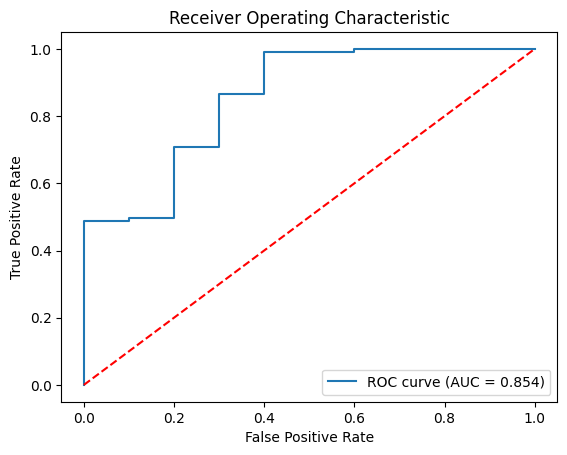

Total images processed: 337
Optimal Threshold found = 0.26 (F1=0.991)
ROC AUC: 0.854
Precision: 0.982
Recall:    1.000
F1-score:  0.991

Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.400     0.571        10
           1      0.982     1.000     0.991       325

    accuracy                          0.982       335
   macro avg      0.991     0.700     0.781       335
weighted avg      0.982     0.982     0.978       335



In [26]:
###############################################################################
# 5) Compute metrics (with threshold optimization to handle imbalance)
###############################################################################
y_true = np.array(y_true)
y_score = np.array(y_score)

print("\n================ METRICS EVALUATION ================")
if len(y_true) == 0:
    print("No valid faces processed. Cannot compute metrics.")
else:
    # 5a) ROC Curve & AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    # 5b) Plot ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    # 5c) Find best threshold to maximize F1
    best_thr, best_f1_score = find_best_threshold(y_true, y_score)
    y_pred = (y_score >= best_thr).astype(int)

    # 5d) Compute final metrics at best threshold
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"Total images processed: {total_images}")
    print(f"Optimal Threshold found = {best_thr:.2f} (F1={best_f1_score:.3f})")
    print(f"ROC AUC: {roc_auc:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1-score:  {f1:.3f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=3, zero_division=0))

In [16]:
import os
import cv2
import numpy as np
import pandas as pd

from insightface.app import FaceAnalysis

In [17]:
# configure face analysis
# faceapp = FaceAnalysis(name='buffalo_l', root='insightface_model', providers=['CPUExecutionProvider'])
faceapp = FaceAnalysis(name='buffalo_m', root='insightface_model', providers=['CPUExecutionProvider'])
# faceapp = FaceAnalysis(name='buffalo_s', root='insightface_model', providers=['CPUExecutionProvider'])
# faceapp = FaceAnalysis(name='buffalo_sc', root='insightface_model', providers=['CPUExecutionProvider'])
# faceapp = FaceAnalysis(name='antelopev2', root='insightface_model', providers=['CPUExecutionProvider'])
faceapp.prepare(ctx_id=0, det_size=(640,640), det_thresh=0.5)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_m\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_m\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_m\det_2.5g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_m\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_m\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


### Extract facial features and labels

In [18]:
# regular expression
import re

In [19]:
# fn to remove any hypen or special char between the first & last name
def clean_name(string):
    string = re.sub(r'[^A-Za-z]',' ', string)
    string = string.title()
    return string

# clean_name('chris_evans')

In [20]:
# Return a list containing the names of the files in the directory.
# os.listdir()

# Return a list inside images folder containing the names of the files in the directory.
# os.listdir(path='images')
# os.listdir(path='images/student-Angelina Jolie')
person_info = []
listdir = os.listdir(path='images')


# 0 - role, 1 - name
for folder_name in listdir:
    print(f"Processing folder: {folder_name}")
    role, name = folder_name.split('-')
    name = clean_name(name);
    role = clean_name(role)
    # print('role :', role, end='\t')
    # print('name :', name)

    # path of each folder in respective folder
    img_files = os.listdir(path=f'images/{folder_name}')
    # print(img_files)
    for file in img_files:
        path = f'./images/{folder_name}/{file}'
        # print(path)

        # step-1 : read the image
        img_arr = cv2.imread(path)

        # step-2 : get the info
        result = faceapp.get(img_arr, max_num=1); # return lists
        # print(result[0].keys())
        # print(result)
        
        if len(result) > 0:
            # step-3 : extract facial embedding
            res = result[0]
            # print(res.keys())
            embedding = res['embedding']
            # step-4 : save all info, name, role, embedding in a list
            person_info.append([name, role, embedding])


Processing folder: student-aaron
Processing folder: student-abdullah
Processing folder: student-abhay
Processing folder: student-aditi
Processing folder: student-Aditi_Sunil
Processing folder: student-aisvarrya
Processing folder: student-alastair
Processing folder: student-ali
Processing folder: student-Allyson_Felix
Processing folder: student-Alvaro_Uribe
Processing folder: student-Amelia_Vega
Processing folder: student-Amelie_Mauresmo
Processing folder: student-Amresh_Chaurasiya
Processing folder: student-anki
Processing folder: student-ankita
Processing folder: student-ankur
Processing folder: student-arun
Processing folder: student-asaqin
Processing folder: student-ashi
Processing folder: student-ashu
Processing folder: student-asit
Processing folder: student-ayusha
Processing folder: student-Benazir_Bhutto
Processing folder: student-Ben_Affleck
Processing folder: student-Bill_Clinton
Processing folder: student-Bill_Frist
Processing folder: student-binks
Processing folder: student-

In [21]:
# The name, role, embedding is inside the person_info array
# print(person_info)

# table to see data easily
dataframe = pd.DataFrame(person_info, columns=['Name', 'Role', 'Facial_Features'])

# store in redis
dataframe

# for idx, se in enumerate(dataframe["Facial_Features"]):
#     print(f"Index: {idx}, Type: {type(se)}, Length: {len(se) if hasattr(se, '__len__') else 'N/A'}")


,Name,Role,Facial_Features
0,Aaron,Student,"[-0.45143485, -1.6528509, 1.4327767, -0.422060..."
1,Aaron,Student,"[-0.023353167, -1.446713, -0.01197511, 0.55963..."
2,Abdullah,Student,"[0.67012125, 0.2842313, -0.38369584, -0.832357..."
3,Abdullah,Student,"[0.28978798, 0.6967961, 0.7232432, -1.2484474,..."
4,Abhay,Student,"[-0.5529244, 0.14004476, 0.34776747, -0.144605..."
...,...,...,...
615,Barack Obama,Teacher,"[0.24614769, 2.2939146, -0.446414, 0.38132536,..."
616,Kevin Costner,Teacher,"[0.28802976, -0.1992543, 0.79165375, 1.4139532..."
617,Kevin Costner,Teacher,"[0.28918687, 0.4805426, -0.18701568, 0.7372142..."
618,Kevin Costner,Teacher,"[0.7647826, -0.10037294, 1.425595, -0.06670301..."


### INFERENCE STAGE

NEW PERSON IMAGE  -> FEATURE EXTRACTION -> MACHINE LEARNING SEARCH ALGO -> PERSON NAME

1. Take new person image
2. Extract feature from the image
3. apply ml search algo in db & extract person name 

In [22]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise
from sklearn.metrics import (
    roc_curve, auc,
    precision_score, recall_score, f1_score,
    classification_report
)
import matplotlib.pyplot as plt

# ---------------------- PREPARE YOUR DATAFRAME ----------------------
# Ensure you already have 'dataframe' with columns ['Name', 'Role', 'Facial_Features']
# We'll assume "dataframe" and "person_info" are defined just as in your code.

if 'dataframe' not in locals():
    print("Error: dataframe is not defined. Creating from person_info...")
    dataframe = pd.DataFrame(person_info, columns=['Name', 'Role', 'Facial_Features'])

X_list = dataframe['Facial_Features'].tolist()
X = np.asarray(X_list)  # Convert to NumPy array

# ---------------------- TEST FOLDER CONFIG ----------------------
root_folder = 'test_folder'
total_images = 0

# Arrays to store ground truth & predicted info for ROC / Precision / Recall, etc.
y_true = []   # 1 if the system's top match is correct, else 0
y_score = []  # the confidence score for the top match (e.g., cosine similarity)

# ---------------------- MAIN LOOP: EVALUATE EACH TEST IMAGE ----------------------
for person_name in os.listdir(root_folder):
    person_path = os.path.join(root_folder, person_name)

    if os.path.isdir(person_path):
        # Normalize the actual name from the folder (remove prefixes and underscores)
        actual_name_cleaned = person_name.lower().replace("student-", "").replace("teacher-", "").replace("_", " ")

        # Process each image within the folder
        for image_name in os.listdir(person_path):
            image_path = os.path.join(person_path, image_name)
            img_test = cv2.imread(image_path)

            if img_test is None:
                print(f"Skipping {image_path} (Invalid Image)")
                continue

            total_images += 1

            # Extract face embeddings from test image
            res_test = faceapp.get(img_test, max_num=0)
            if not res_test:
                print(f"No face detected in {image_name}")
                continue
            
            rt = res_test[0]
            embed_test = rt['embedding'].reshape(1, -1)

            # Compute cosine similarity between the test embedding and all reference embeddings
            cosine_similar = pairwise.cosine_similarity(X, embed_test).flatten()
            
            # Choose best match
            best_match_index = np.argmax(cosine_similar)
            predicted_name = dataframe.loc[best_match_index]['Name'].lower()
            
            # Check if the predicted name is contained in the cleaned actual name
            if predicted_name in actual_name_cleaned:
                y_true.append(1)
            else:
                y_true.append(0)
            
            # Save the confidence score (cosine similarity of the best match)
            best_match_score = cosine_similar[best_match_index]
            y_score.append(best_match_score)

            # (Optional) Print info for each image
            print(f"Image: {image_name} → Predicted: {predicted_name}, "
                  f"Actual: {actual_name_cleaned}, Score: {best_match_score:.4f}")


Image: Aaron_1.jpg → Predicted: aaron, Actual: aaron, Score: 0.7824
Image: Aaron_2.jpg → Predicted: aaron, Actual: aaron, Score: 0.6261
Image: Abdullah_1.jpg → Predicted: abdullah, Actual: abdullah, Score: 0.6962
Image: Abdullah_2.jpg → Predicted: abdullah, Actual: abdullah, Score: 0.7544
Image: abhay_1.jpeg → Predicted: abhay, Actual: abhay, Score: 0.9110
Image: abhay_2.jpeg → Predicted: abhay, Actual: abhay, Score: 0.8683
Image: abhay_3.jpeg → Predicted: abhay, Actual: abhay, Score: 0.9132
Image: abhay_4.jpeg → Predicted: abhay, Actual: abhay, Score: 0.9042
Image: abhay_5.jpeg → Predicted: abhay, Actual: abhay, Score: 0.9011
Image: aditi_1.jpeg → Predicted: aditi, Actual: aditi, Score: 0.8643
Image: aditi_2.jpeg → Predicted: aditi, Actual: aditi, Score: 0.8436
Image: aditi_3.jpeg → Predicted: aditi, Actual: aditi, Score: 0.9363
Image: aditi_4.jpeg → Predicted: aditi, Actual: aditi, Score: 0.9322
Image: aditi_5.jpeg → Predicted: aditi, Actual: aditi, Score: 0.9090
Image: aditi_6.jpeg 

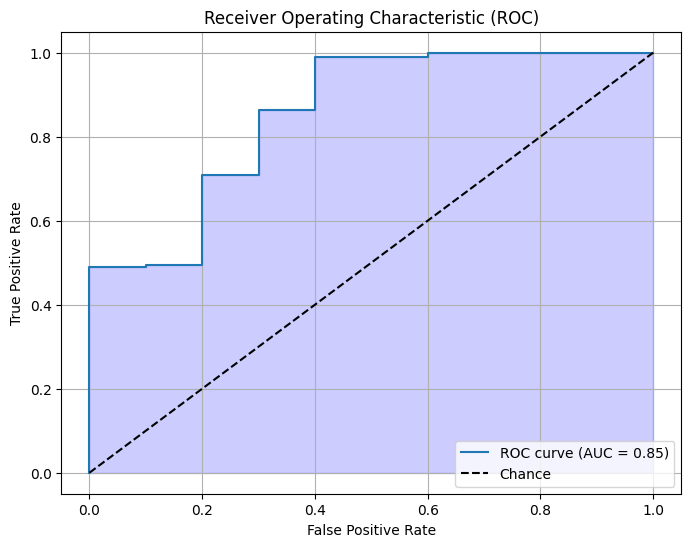

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_true and y_score are already defined as your ground truth labels and similarity scores
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
# Use step function to plot the ROC curve
plt.step(fpr, tpr, where='post', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')

# Plot a diagonal line for random performance
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



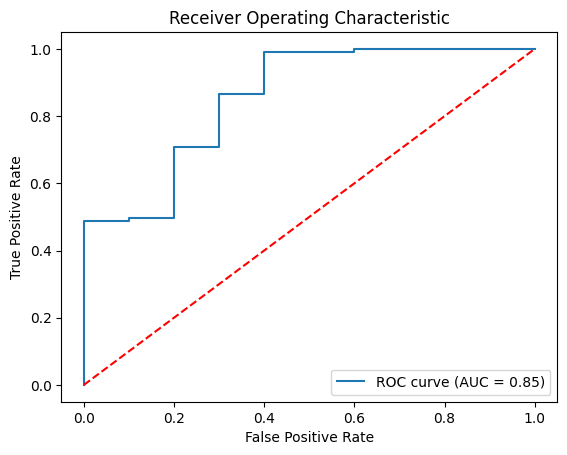

Total images processed: 337
ROC AUC: 0.854
Precision: 0.988
Recall:    0.988
F1-score:  0.988

Classification Report:
              precision    recall  f1-score   support

           0      0.600     0.600     0.600        10
           1      0.988     0.988     0.988       325

    accuracy                          0.976       335
   macro avg      0.794     0.794     0.794       335
weighted avg      0.976     0.976     0.976       335



In [24]:
# ---------------------- METRICS EVALUATION ----------------------
y_true = np.array(y_true)
y_score = np.array(y_score)

if len(y_true) == 0:
    print("No valid faces were processed, cannot compute metrics.")
else:
    # 1) Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    # 2) Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'r--')  # Reference line for random classifier
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    # 3) Choose a threshold (e.g., 0.5) for classification
    threshold_for_classification = 0.5
    y_pred = (y_score >= threshold_for_classification).astype(int)

    # 4) Compute Precision, Recall, and F1 with zero_division parameter to avoid warnings
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"Total images processed: {total_images}")
    print(f"ROC AUC: {roc_auc:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1-score:  {f1:.3f}")

    # 5) Print Classification Report with zero_division set
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=3, zero_division=0))

## 1. IMAGE IDENTIFICATION

In [44]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt

if 'dataframe' not in locals():
    print("Error: dataframe is not defined. Creating from person_info...")
    dataframe = pd.DataFrame(person_info, columns=['Name', 'Role', 'Facial_Features'])

X_list = dataframe['Facial_Features'].tolist()
X = np.asarray(X_list)  # Convert to NumPy array
print(f"Data loaded successfully: {X.shape}")

# Define root folder
root_folder = 'test_folder'

# Loop through each subfolder and image
for person_name in os.listdir(root_folder):
    person_path = os.path.join(root_folder, person_name)
    
    if os.path.isdir(person_path):  # Check if it's a folder
        print(f"\nProcessing images for: {person_name}\n" + "-"*30)
        
        for image_name in os.listdir(person_path):
            image_path = os.path.join(person_path, image_name)
            img_test = cv2.imread(image_path)

            if img_test is None:
                print(f"Skipping {image_path} (Invalid Image)")
                continue

            # Show Image (Optional)
            cv2.imshow(f'{person_name} test', img_test)
            cv2.waitKey(500)  # Show for 500ms
            cv2.destroyAllWindows()

            # Extract face embeddings
            res_test = faceapp.get(img_test, max_num=0)
            
            if not res_test:
                print(f"No face detected in {image_name}")
                continue
            
            rt = res_test[0]
            embed_test = rt['embedding']

            # Compute distances
            y = embed_test.reshape(1, 512)
            euclidean_distance = pairwise.euclidean_distances(X, y)
            manhattan_distance = pairwise.manhattan_distances(X, y)
            cosine_similar = pairwise.cosine_similarity(X, y)

            # Store results
            data_search = dataframe.copy()
            data_search['euclidean'] = euclidean_distance
            data_search['manhattan'] = manhattan_distance
            data_search['cosine'] = cosine_similar

            # Filter based on optimal euclidean distance
            d_eq_optimal = 24
            datafilter = data_search.query(f'euclidean < {d_eq_optimal}')
            datafilter.reset_index(drop=True, inplace=True)

            if len(datafilter) > 0:
                argmin = datafilter['euclidean'].argmin()
                eq_name, eq_role = datafilter.loc[argmin][['Name', 'Role']]
            else:
                eq_name, eq_role = "Unknown", "Unknown"

            print(f"Image: {image_name} → Identified as: {eq_name} ({eq_role})")


Data loaded successfully: (223, 512)

Processing images for: student-abhay
------------------------------
Image: abhay_1.jpeg.jpeg → Identified as: Abhay (Student)
Image: abhay_2.jpeg.jpeg → Identified as: Abhay (Student)
Image: abhay_3.jpeg.jpeg → Identified as: Abhay (Student)
Image: abhay_4.jpeg.jpeg → Identified as: Abhay (Student)
Image: abhay_5.jpeg.jpeg → Identified as: Abhay (Student)

Processing images for: student-aditi
------------------------------
Image: aditi_1.jpeg.jpeg → Identified as: Aditi (Student)
Image: aditi_2.jpeg.jpeg → Identified as: Aditi (Student)
Image: aditi_3.jpeg.jpeg → Identified as: Aditi (Student)
Image: aditi_4.jpeg.jpeg → Identified as: Aditi (Student)
Image: aditi_5.jpeg.jpeg → Identified as: Aditi (Student)
Image: aditi_6.jpeg.jpeg → Identified as: Aditi (Student)

Processing images for: student-aisvarrya
------------------------------
Image: aisvarrya_1.jpeg.jpeg → Identified as: Aisvarrya (Student)
Image: aisvarrya_2.jpeg.jpeg → Identified as: Ai

## 2. ACCURACY CALCULATION USING EUCLIDEAN METHOD

In [19]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise

# Ensure dataframe exists
if 'dataframe' not in locals():
    print("Error: dataframe is not defined. Creating from person_info...")
    dataframe = pd.DataFrame(person_info, columns=['Name', 'Role', 'Facial_Features'])

X_list = dataframe['Facial_Features'].tolist()
X = np.asarray(X_list)  # Convert to NumPy array
print(f"Data loaded successfully: {X.shape}")

# Define root folder
root_folder = 'test_folder'

# Accuracy Counters
total_images = 0
correct_predictions = 0

# Loop through each subfolder (each person's images)
for person_name in os.listdir(root_folder):
    person_path = os.path.join(root_folder, person_name)

    if os.path.isdir(person_path):  # Ensure it's a folder
        print(f"\nProcessing images for: {person_name}\n" + "-"*30)

        for image_name in os.listdir(person_path):
            image_path = os.path.join(person_path, image_name)
            img_test = cv2.imread(image_path)

            if img_test is None:
                print(f"Skipping {image_path} (Invalid Image)")
                continue

            total_images += 1  # Counting total images

            # Extract face embeddings
            res_test = faceapp.get(img_test, max_num=0)
            
            if not res_test:
                print(f"No face detected in {image_name}")
                continue
            
            rt = res_test[0]
            embed_test = rt['embedding']

            # Compute distances
            y = embed_test.reshape(1, 512)
            euclidean_distance = pairwise.euclidean_distances(X, y)
            manhattan_distance = pairwise.manhattan_distances(X, y)
            cosine_similar = pairwise.cosine_similarity(X, y)

            # Store results
            data_search = dataframe.copy()
            data_search['euclidean'] = euclidean_distance
            data_search['manhattan'] = manhattan_distance
            data_search['cosine'] = cosine_similar

            # Filter based on optimal euclidean distance
            d_eq_optimal = 24
            datafilter = data_search.query(f'euclidean < {d_eq_optimal}')
            datafilter.reset_index(drop=True, inplace=True)

            if len(datafilter) > 0:
                argmin = datafilter['euclidean'].argmin()
                eq_name, eq_role = datafilter.loc[argmin][['Name', 'Role']]
            else:
                eq_name, eq_role = "Unknown", "Unknown"

            # Normalize names for comparison
            predicted_name = eq_name.lower()
            actual_name = person_name.lower().replace("student-", "")  # Remove "student-" prefix

            # Check if prediction is correct
            if predicted_name in actual_name:  # Partial match handling
                correct_predictions += 1

            print(f"Image: {image_name} → Predicted: {eq_name}, Actual: {person_name}")

# Compute Accuracy
accuracy = (correct_predictions / total_images) * 100 if total_images > 0 else 0
print(f"\nOverall Model Accuracy: {accuracy:.2f}%")

Data loaded successfully: (323, 512)

Processing images for: student-aaron
------------------------------
Image: Aaron_1.jpg → Predicted: Aaron, Actual: student-aaron
Image: Aaron_2.jpg → Predicted: Aaron, Actual: student-aaron

Processing images for: student-abdullah
------------------------------
Image: Abdullah_1.jpg → Predicted: Abdullah, Actual: student-abdullah
Image: Abdullah_2.jpg → Predicted: Abdullah, Actual: student-abdullah

Processing images for: student-abhay
------------------------------
Image: abhay_1.jpeg → Predicted: Abhay, Actual: student-abhay
Image: abhay_2.jpeg → Predicted: Abhay, Actual: student-abhay
Image: abhay_3.jpeg → Predicted: Abhay, Actual: student-abhay
Image: abhay_4.jpeg → Predicted: Abhay, Actual: student-abhay
Image: abhay_5.jpeg → Predicted: Abhay, Actual: student-abhay

Processing images for: student-aditi
------------------------------
Image: aditi_1.jpeg → Predicted: Aditi, Actual: student-aditi
Image: aditi_2.jpeg → Predicted: Aditi, Actual: st

## 3. ACCURACY CALCULATION USING COSINE SIMILARITY

In [20]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise

# Ensure dataframe exists
if 'dataframe' not in locals():
    print("Error: dataframe is not defined. Creating from person_info...")
    dataframe = pd.DataFrame(person_info, columns=['Name', 'Role', 'Facial_Features'])

X_list = dataframe['Facial_Features'].tolist()
X = np.asarray(X_list)  # Convert to NumPy array
print(f"Data loaded successfully: {X.shape}")

# Define root folder
root_folder = 'test_folder'

# Accuracy Counters
total_images = 0
correct_predictions = 0

# Loop through each subfolder (each person's images)
for person_name in os.listdir(root_folder):
    person_path = os.path.join(root_folder, person_name)

    if os.path.isdir(person_path):  # Ensure it's a folder
        print(f"\nProcessing images for: {person_name}\n" + "-"*30)

        for image_name in os.listdir(person_path):
            image_path = os.path.join(person_path, image_name)
            img_test = cv2.imread(image_path)

            if img_test is None:
                print(f"Skipping {image_path} (Invalid Image)")
                continue

            total_images += 1  # Counting total images

            # Extract face embeddings
            res_test = faceapp.get(img_test, max_num=0)
            
            if not res_test:
                print(f"No face detected in {image_name}")
                continue
            
            rt = res_test[0]
            embed_test = rt['embedding']

            # Compute distances
            y = embed_test.reshape(1, 512)
            cosine_similar = pairwise.cosine_similarity(X, y)

            # Store results
            data_search = dataframe.copy()
            data_search['cosine'] = cosine_similar

            # Find the best match based on cosine similarity
            best_match_index = data_search['cosine'].idxmax()  # Highest similarity
            predicted_name = data_search.loc[best_match_index]['Name'].lower()

            # Normalize actual name (remove 'student-' or 'teacher-')
            actual_name = person_name.lower().replace("student-", "").replace("teacher-", "")
            actual_name = actual_name.replace("_", " ")
            print(actual_name)

            # Check if prediction is correct
            if predicted_name in actual_name:  # Partial match handling
                correct_predictions += 1

            print(f"Image: {image_name} → Predicted: {predicted_name}, Actual: {person_name}")

# Compute Accuracy
accuracy = (correct_predictions / total_images) * 100 if total_images > 0 else 0
print(f"\nOverall Model Accuracy: {accuracy:.2f}%")


Data loaded successfully: (323, 512)

Processing images for: student-aaron
------------------------------
aaron
Image: Aaron_1.jpg → Predicted: aaron, Actual: student-aaron
aaron
Image: Aaron_2.jpg → Predicted: aaron, Actual: student-aaron

Processing images for: student-abdullah
------------------------------
abdullah
Image: Abdullah_1.jpg → Predicted: abdullah, Actual: student-abdullah
abdullah
Image: Abdullah_2.jpg → Predicted: abdullah, Actual: student-abdullah

Processing images for: student-abhay
------------------------------
abhay
Image: abhay_1.jpeg → Predicted: abhay, Actual: student-abhay
abhay
Image: abhay_2.jpeg → Predicted: abhay, Actual: student-abhay
abhay
Image: abhay_3.jpeg → Predicted: abhay, Actual: student-abhay
abhay
Image: abhay_4.jpeg → Predicted: abhay, Actual: student-abhay
abhay
Image: abhay_5.jpeg → Predicted: abhay, Actual: student-abhay

Processing images for: student-aditi
------------------------------
aditi
Image: aditi_1.jpeg → Predicted: aditi, Actual

## 4. Research-Grade Accuracy Calculation (Recommended Approach)

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Counters for calculating Precision, Recall, F1-score
true_positive = 0
false_positive = 0
false_negative = 0
total_images = 0

for person_name in os.listdir(root_folder):
    person_path = os.path.join(root_folder, person_name)

    if os.path.isdir(person_path):
        actual_name = person_name.lower().replace("student-", "").replace("teacher-", "")

        for image_name in os.listdir(person_path):
            image_path = os.path.join(person_path, image_name)
            img_test = cv2.imread(image_path)

            if img_test is None:
                continue

            total_images += 1

            # Face detection
            res_test = faceapp.get(img_test, max_num=0)
            if not res_test:
                false_negative += 1
                continue

            rt = res_test[0]
            embed_test = rt['embedding']

            # Cosine Similarity Calculation
            y = embed_test.reshape(1, 512)
            cosine_similar = pairwise.cosine_similarity(X, y)

            # Find best match
            best_match_index = np.argmax(cosine_similar)
            predicted_name = dataframe.loc[best_match_index]['Name'].lower()

            if predicted_name in actual_name:
                true_positive += 1
            else:
                false_positive += 1

# **Calculate Metrics**
precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Precision: 0.67
Recall: 0.80
F1-Score: 0.73


Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


C:\Users\tanya\OneDrive\Desktop\Face Recognition Attendance System - Copy - Copy\Attendance_System\Notes\attendance_system\lib\site-packages\sklearn\metrics\_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


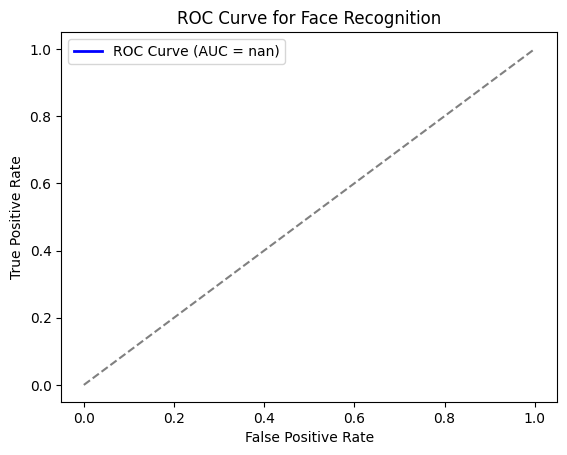

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Sample embeddings & names (Replace with actual embeddings from your model)
actual_names = ["Alice", "Bob", "Charlie", "David"]
predicted_names = ["Alice", "Bob", "Charlie", "David"]
roles = ["Teacher", "Student", "Teacher", "Student"]  # This will be ignored in accuracy calculation

# Generate random embeddings for demo (Replace with actual feature vectors)
np.random.seed(42)
actual_embeddings = np.random.rand(len(actual_names), 128)
predicted_embeddings = actual_embeddings + (np.random.rand(len(actual_names), 128) * 0.1)  # Slight variation

# Store ground truth labels and scores for evaluation
y_true = []
y_scores = []

# Iterate over embeddings
for i in range(len(actual_names)):
    # Compute cosine similarity
    similarity_score = cosine_similarity(
        actual_embeddings[i].reshape(1, -1), predicted_embeddings[i].reshape(1, -1)
    )[0][0]
    
    # Consider only name for accuracy, ignoring role
    is_correct = actual_names[i].lower() == predicted_names[i].lower()
    
    # Store results
    y_true.append(1 if is_correct else 0)  # 1 for correct, 0 for incorrect
    y_scores.append(similarity_score)  # Store similarity score

# Convert to numpy arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Compute Metrics
accuracy = accuracy_score(y_true, y_scores >= 0.5)  # Threshold at 0.5
precision = precision_score(y_true, y_scores >= 0.5)
recall = recall_score(y_true, y_scores >= 0.5)
f1 = f1_score(y_true, y_scores >= 0.5)

# Print Results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# ROC Curve Calculation
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="grey", linestyle="--")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Face Recognition")
plt.legend()
plt.show()


## ACCURACY CALCULATION

## 1. Phle facial embedding ko store krenge

In [28]:
import os
import cv2
import numpy as np
import pandas as pd

# Path to database images
image_folder = "images"

# List to store extracted embeddings
person_info = []

# Process each person's folder
for folder_name in os.listdir(image_folder):
    print(f"Processing folder: {folder_name}")

    role, name = folder_name.split('-')  # Folder name format: "Role-Name"
    
    # Extract images from folder
    img_files = os.listdir(os.path.join(image_folder, folder_name))
    for file in img_files:
        img_path = os.path.join(image_folder, folder_name, file)

        # Read the image
        img_arr = cv2.imread(img_path)
        if img_arr is None:
            print(f"Skipping {img_path}, couldn't read image.")
            continue

        # Get facial embedding
        result = faceapp.get(img_arr, max_num=1)
        if len(result) == 0:
            print(f"No face detected in {file}, skipping...")
            continue

        embedding = result[0]['embedding']

        # Store name, role, and embedding
        person_info.append([name, role, embedding])

# Convert to dataframe
dataframe = pd.DataFrame(person_info, columns=['Name', 'Role', 'Facial_Features'])

# Save dataframe to CSV
dataframe.to_csv("facial_data.csv", index=False)

print("✅ Facial embeddings stored in 'facial_data.csv'.")


Processing folder: student-Aaron_Peirsol
Processing folder: student-Abdullah
Processing folder: student-abhay
Processing folder: student-Aditi
Processing folder: student-adnan
Processing folder: student-Aisvarrya
Processing folder: student-Alastair_Campbell
Processing folder: student-Alec_Baldwin
Processing folder: student-Ali_Naimi
Processing folder: student-Allyson_Felix
Processing folder: student-Alvaro_Uribe
Processing folder: student-Amanda_Bynes
Processing folder: student-Amelia_Vega
Processing folder: student-Amelie_Mauresmo
Processing folder: student-ankita
Processing folder: student-ankur
Processing folder: student-asit
Processing folder: student-Ayusha
Processing folder: student-Barbara_Walters
Processing folder: student-Bashar_Assad
Processing folder: student-Benazir_Bhutto
Processing folder: student-Ben_Affleck
Processing folder: student-Bertie_Ahern
Processing folder: student-Bill_Clinton
Processing folder: student-Bill_Frist
Processing folder: student-Binyamin_Ben
Process

## 2. Calculating accuracy

In [30]:
import os
import cv2
import numpy as np
import pandas as pd
import ast
from sklearn.metrics import pairwise

# Load stored facial embeddings from CSV
dataframe = pd.read_csv("facial_data.csv")  

# Convert stored embeddings (string to list)
dataframe['Facial_Features'] = dataframe['Facial_Features'].apply(ast.literal_eval)  # Correct parsing
X_list = dataframe['Facial_Features'].tolist()
X = np.asarray(X_list)  # Convert to NumPy array

# Path to test images
test_folder_path = "test_folder"

# Accuracy counters
correct_predictions = 0
total_test_images = 0

# Process each person's folder in test_folder
for folder_name in os.listdir(test_folder_path):
    print(f"Processing folder: {folder_name}")

    actual_name = folder_name  # Test folder name is the person's actual name

    for file_name in os.listdir(os.path.join(test_folder_path, folder_name)):
        total_test_images += 1  # Counting total test images
        image_path = os.path.join(test_folder_path, folder_name, file_name)

        # Read test image
        img_test = cv2.imread(image_path)
        if img_test is None:
            print(f"Skipping {image_path}, couldn't read image.")
            continue

        # Extract facial embedding
        result = faceapp.get(img_test, max_num=1)
        if len(result) == 0:
            print(f"No face detected in {file_name}, skipping...")
            continue

        embed_test = result[0]['embedding']
        y = np.asarray(embed_test).reshape(1, -1)  # Ensure correct shape

        # Compute distances
        equlidean_distance = pairwise.euclidean_distances(X, y)

        # Find best match
        data_search = dataframe.copy()
        data_search['equlidean'] = equlidean_distance

        if len(data_search) > 0:
            argmin = data_search['equlidean'].argmin()
            predicted_name = data_search.loc[argmin]['Name']
        else:
            predicted_name = "Unknown"

        # Check correctness
        if predicted_name == actual_name:
            correct_predictions += 1

# Calculate accuracy
if total_test_images > 0:
    accuracy = (correct_predictions / total_test_images) * 100
    print(f"Face Recognition Accuracy: {accuracy:.2f}%")
else:
    print("No test images found.")


SyntaxError: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)

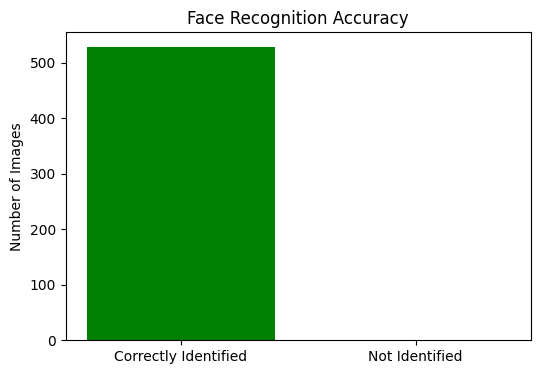

In [15]:
import matplotlib.pyplot as plt

labels = ['Correctly Identified', 'Not Identified']
values = [correctly_identified, total_images - correctly_identified]

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['green', 'red'])
plt.title("Face Recognition Accuracy")
plt.ylabel("Number of Images")
plt.show()


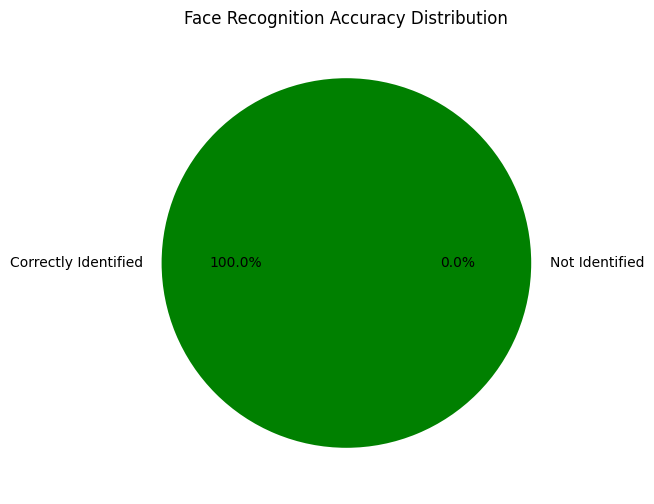

In [16]:
plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=['green', 'red'])
plt.title("Face Recognition Accuracy Distribution")
plt.show()

### Step-1 : Read test image (TEST IMAGE SINGLE)

In [7]:
# img_test = cv2.imread('test_images/test_2.jpeg')
img_test = cv2.imread('test_images/ankur_test.jpg')

cv2.imshow('ankur test', img_test)
cv2.waitKey(0)
cv2.destroyAllWindows()

#### Step-2 : Extract the features 

In [9]:
res_test = faceapp.get(img_test, max_num=0)
# print(result_test)

for i,rt in enumerate(res_test):
    print('current loop =',i)
    bbox = rt['bbox'].astype(int)
    score = int(rt['det_score']*100)
    embed_test = rt['embedding']
    

current loop = 0


In [10]:
# ONLY 1 SAMPLE IMAGE (no of dimensions in 1 image)
len(embed_test)

512

### Compare the test image facial embedding with all facial embedding avl inside the dataframe

In [11]:
dataframe.head()

,Name,Role,Facial_Features
0,Aaron Peirsol,Student,"[-0.36875662, -1.6064843, 1.2511821, -0.399673..."
1,Aaron Peirsol,Student,"[-0.0011554584, -1.368503, -0.047049314, 0.508..."
2,Aaron Peirsol,Student,"[0.792392, -0.78379166, 0.58785343, 0.96419513..."
3,Aaron Peirsol,Student,"[0.118267804, 0.222576, 0.58508193, -0.4207472..."
4,Abdullah,Student,"[0.63822305, 0.2289042, -0.31736904, -0.791751..."


In [12]:
# convert list to array
X_list = dataframe['Facial_Features'].tolist()
X = np.asarray(X_list)

print(f"x.shape: {X.shape}")

x.shape: (528, 512)


In [13]:
# each 50 samples has 512 dimensions
X.shape

(528, 512)

In [14]:
from sklearn.metrics import pairwise

In [15]:
# euclidean , manhattan distance, cosine similarity

y = embed_test.reshape(1, 512) # reshape to row vector, 1 * 512

equlidean_distance = pairwise.euclidean_distances(X, y)
manhattan_distance = pairwise.manhattan_distances(X, y)
cosine_similar = pairwise.cosine_similarity(X, y)

In [16]:
data_search = dataframe.copy()
data_search['equlidean'] = equlidean_distance
data_search['manhattan'] = manhattan_distance
data_search['cosine'] = cosine_similar

In [17]:
data_search

,Name,Role,Facial_Features,equlidean,manhattan,cosine
0,Aaron Peirsol,Student,"[-0.36875662, -1.6064843, 1.2511821, -0.399673...",34.908279,626.991205,-0.037387
1,Aaron Peirsol,Student,"[-0.0011554584, -1.368503, -0.047049314, 0.508...",34.127148,614.519193,-0.020184
2,Aaron Peirsol,Student,"[0.792392, -0.78379166, 0.58785343, 0.96419513...",33.000774,591.832524,-0.040231
3,Aaron Peirsol,Student,"[0.118267804, 0.222576, 0.58508193, -0.4207472...",32.729618,584.139075,0.074894
4,Abdullah,Student,"[0.63822305, 0.2289042, -0.31736904, -0.791751...",34.142910,619.832272,0.001618
...,...,...,...,...,...,...
523,Kevin Costner,Teacher,"[0.29962462, -0.19945751, 1.0537453, 1.3018793...",31.851591,576.389880,0.048388
524,Kevin Costner,Teacher,"[0.11820501, 0.4532351, -0.01092504, 0.8051185...",32.416153,586.379848,0.000574
525,Kevin Costner,Teacher,"[-0.012068391, -6.970763e-05, 0.55693746, 0.55...",31.353462,563.916758,0.049395
526,Kevin Costner,Teacher,"[0.8007083, 0.019446418, 1.3690064, -0.0333238...",30.985430,549.518814,0.018415


In [18]:
import matplotlib.pyplot as plt

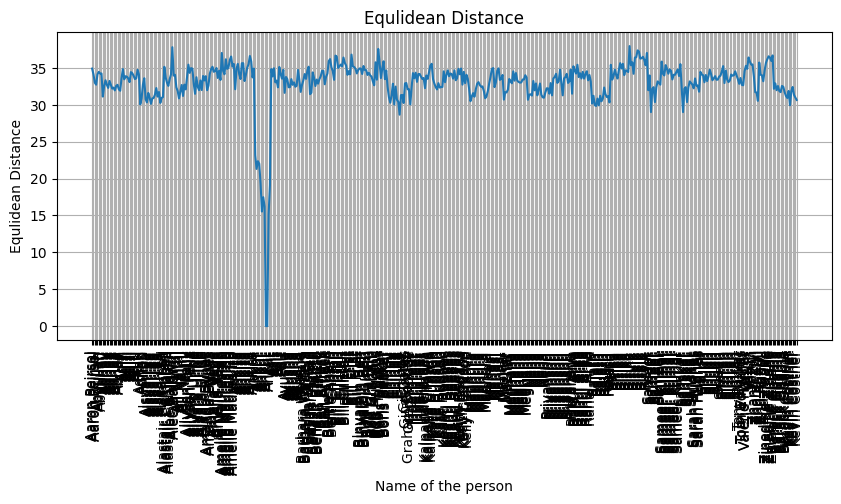

In [19]:
# Equlidean
# X axis : row no / record no
# Y axis : distance

plt.figure(figsize=(10,4))
plt.plot(data_search['equlidean'])
plt.xticks(ticks=list(range(len(data_search['equlidean']))), labels=data_search['Name'], rotation=90)
plt.title("Equlidean Distance")
plt.xlabel('Name of the person')
plt.ylabel('Equlidean Distance')

plt.grid()
plt.show()

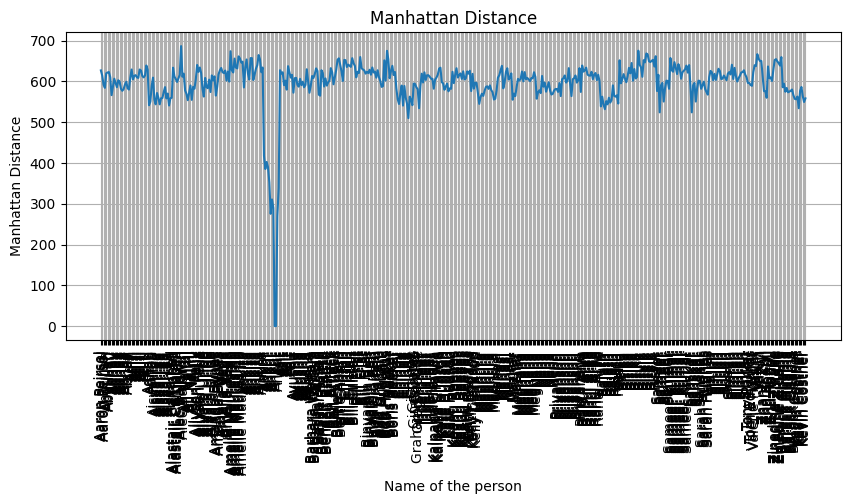

In [20]:
# Manhattan distance
# X axis : row no / record no
# Y axis : distance

plt.figure(figsize=(10,4))
plt.plot(data_search['manhattan'])
plt.xticks(ticks=list(range(len(data_search['manhattan']))), labels=data_search['Name'], rotation=90)
plt.title("Manhattan Distance")
plt.xlabel('Name of the person')
plt.ylabel('Manhattan Distance')

plt.grid()
plt.show()

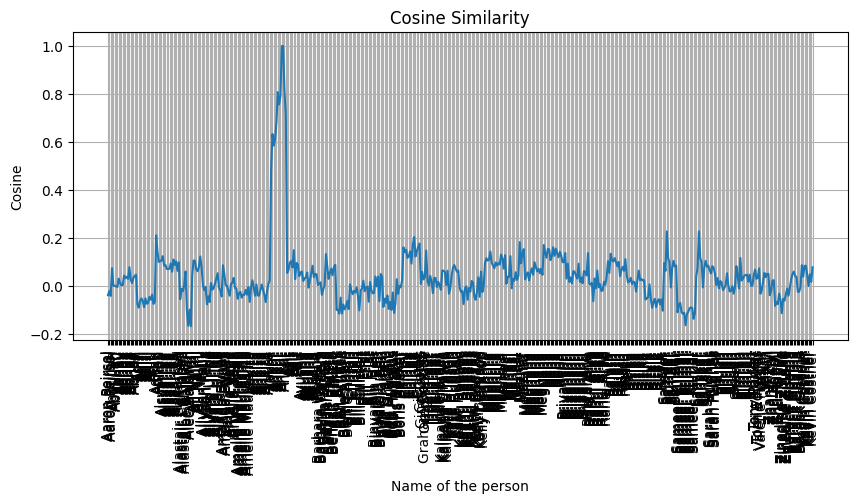

In [21]:
# Cosine Similarity
# X axis : row no / record no
# Y axis : distance

plt.figure(figsize=(10,4))
plt.plot(data_search['cosine'])
plt.xticks(ticks=list(range(len(data_search['cosine']))), labels=data_search['Name'], rotation=90)
plt.title("Cosine Similarity")
plt.xlabel('Name of the person')
plt.ylabel('Cosine')

plt.grid()
plt.show()

## Finding person name using Equilidean distance
- Threshold point afer analysing the graph : **24**
- The data points having distance < 24 will be considered similar

In [22]:
# optimal distance
d_eq_optimal = 24

In [23]:
# filtering data which have distance < 24
datafilter = data_search.query(f'equlidean < {d_eq_optimal} ')
datafilter.reset_index(drop=True, inplace=True)
datafilter

,Name,Role,Facial_Features,equlidean,manhattan,cosine
0,Ankur,Student,"[0.7779857, -0.03811796, 1.1893519, 0.05837321...",23.169655,417.621614,0.483628
1,Ankur,Student,"[2.1729677, 2.4065566, 0.4054818, 1.3251727, -...",21.307894,385.243934,0.633745
2,Ankur,Student,"[1.1897379, 1.0526358, 0.10993977, 0.7051736, ...",22.354883,402.518496,0.585781
3,Ankur,Student,"[2.8977525, 1.0185622, 0.46433765, 0.025556525...",22.005857,389.718195,0.614554
4,Ankur,Student,"[1.0488771, 1.8901161, 0.76555806, -0.490861, ...",19.301537,352.433308,0.683975
5,Ankur,Student,"[1.5364463, 2.000881, -0.36593133, 0.08675748,...",15.530371,275.401995,0.808346
6,Ankur,Student,"[0.9554448, 2.6838737, 0.15807146, 0.13424082,...",17.470402,310.530632,0.757124
7,Ankur,Student,"[2.288479, 2.4059472, -0.57460356, 0.44816342,...",16.207491,289.769283,0.793992
8,Ankur,Student,"[1.7376581, 2.0880282, -0.5564124, 0.45088682,...",0.000000,0.000000,1.000000
9,Ankur,Student,"[1.7376581, 2.0880282, -0.5564124, 0.45088682,...",0.000000,0.000000,1.000000


In [24]:
# find minimum distance among all the data for name extraction & its complete info

if len(datafilter) > 0:
    argmin = datafilter['equlidean'].argmin()
    # print("Index with minimum distance among all the similar data found : ", argmin)
    # print("\n")
    # print(datafilter.loc[argmin])
    eq_name, eq_role = datafilter.loc[argmin][['Name', 'Role']]
else : 
    name = "Unknown"
    role = 'Unknown'

In [25]:
print(eq_role, eq_name)

Student Ankur


## Finding person name using Manhattan distance
- Threshold point afer analysing the graph : **450**
- The data points having distance < 450 will be considered similar

In [26]:
d_mn_optimal = 450

In [27]:
# filtering data which have manhattan distance < 350
datafilter = data_search.query(f'manhattan < {d_mn_optimal} ')
datafilter.reset_index(drop=True, inplace=True)
datafilter

,Name,Role,Facial_Features,equlidean,manhattan,cosine
0,Ankur,Student,"[0.7779857, -0.03811796, 1.1893519, 0.05837321...",23.169655,417.621614,0.483628
1,Ankur,Student,"[2.1729677, 2.4065566, 0.4054818, 1.3251727, -...",21.307894,385.243934,0.633745
2,Ankur,Student,"[1.1897379, 1.0526358, 0.10993977, 0.7051736, ...",22.354883,402.518496,0.585781
3,Ankur,Student,"[2.8977525, 1.0185622, 0.46433765, 0.025556525...",22.005857,389.718195,0.614554
4,Ankur,Student,"[1.0488771, 1.8901161, 0.76555806, -0.490861, ...",19.301537,352.433308,0.683975
5,Ankur,Student,"[1.5364463, 2.000881, -0.36593133, 0.08675748,...",15.530371,275.401995,0.808346
6,Ankur,Student,"[0.9554448, 2.6838737, 0.15807146, 0.13424082,...",17.470402,310.530632,0.757124
7,Ankur,Student,"[2.288479, 2.4059472, -0.57460356, 0.44816342,...",16.207491,289.769283,0.793992
8,Ankur,Student,"[1.7376581, 2.0880282, -0.5564124, 0.45088682,...",0.000000,0.000000,1.000000
9,Ankur,Student,"[1.7376581, 2.0880282, -0.5564124, 0.45088682,...",0.000000,0.000000,1.000000


In [28]:
# find minimum distance among all the data for name extraction & its complete info

if len(datafilter) > 0:
    argmin = datafilter['manhattan'].argmin()
    # print("Index with minimum distance among all the similar data found : ", argmin)
    # print("\n")
    # print(datafilter.loc[argmin])
    mn_name, mn_role = datafilter.loc[argmin][['Name', 'Role']]
else : 
    mn_name = "Unknown"
    mn_role = 'Unknown'

In [29]:
print(mn_name, mn_role)

Ankur Student


## Identify person name using Cosime Similarity
- Threshold point afer analysing the graph : **0.5**
- The data points having cosine value > 0.5 will be considered similar

In [30]:
S_optimal = 0.5

In [31]:
# filtering data which have cosine value > 0.5
datafilter = data_search.query(f'cosine > {S_optimal} ')
datafilter.reset_index(drop=True, inplace=True)
datafilter

,Name,Role,Facial_Features,equlidean,manhattan,cosine
0,Ankur,Student,"[2.1729677, 2.4065566, 0.4054818, 1.3251727, -...",21.307894,385.243934,0.633745
1,Ankur,Student,"[1.1897379, 1.0526358, 0.10993977, 0.7051736, ...",22.354883,402.518496,0.585781
2,Ankur,Student,"[2.8977525, 1.0185622, 0.46433765, 0.025556525...",22.005857,389.718195,0.614554
3,Ankur,Student,"[1.0488771, 1.8901161, 0.76555806, -0.490861, ...",19.301537,352.433308,0.683975
4,Ankur,Student,"[1.5364463, 2.000881, -0.36593133, 0.08675748,...",15.530371,275.401995,0.808346
5,Ankur,Student,"[0.9554448, 2.6838737, 0.15807146, 0.13424082,...",17.470402,310.530632,0.757124
6,Ankur,Student,"[2.288479, 2.4059472, -0.57460356, 0.44816342,...",16.207491,289.769283,0.793992
7,Ankur,Student,"[1.7376581, 2.0880282, -0.5564124, 0.45088682,...",0.000000,0.000000,1.000000
8,Ankur,Student,"[1.7376581, 2.0880282, -0.5564124, 0.45088682,...",0.000000,0.000000,1.000000
9,Ankur,Student,"[0.7436756, 1.2233993, 0.2745173, 0.2972701, -...",15.115596,269.480427,0.815249


In [32]:
# find cosine value among all the data for name extraction & its complete info

if len(datafilter) > 0:
    argmax = datafilter['cosine'].argmax()
    # print("Index with minimum distance among all the similar data found : ", argmax)
    # print("\n")
    print(datafilter.loc[argmax])
    name_cos, role_cos = datafilter.loc[argmax][['Name', 'Role']]
else : 
    name_cos = "Unknown"
    role_cos = 'Unknown'

Name                                                           Ankur
Role                                                         Student
Facial_Features    [1.7376581, 2.0880282, -0.5564124, 0.45088682,...
equlidean                                                        0.0
manhattan                                                        0.0
cosine                                                           1.0
Name: 7, dtype: object


In [33]:
print(name_cos, role_cos)

Ankur Student


### IDENTIFY MULTIPLE PERSONS IN AN IMAGE

In [34]:
def ml_search_algorithm(dataframe, feature_column, test_vector, name_role = ['Name', 'Role'], thresh=0.5) :
    # STEP 1 : Take the dataframe (collection of data)
    dataframe = dataframe.copy();
    
    # STEP 2 : Index face embedding from the dataframe and convert into array
    X_list = dataframe[feature_column].tolist();
    x = np.asarray(X_list);
    print(f"x.shape: {X.shape}")
    
    # STEP 3 : Calculate the COSINE similarity matrix 
    similar = pairwise.cosine_similarity(x, test_vector.reshape(1, -1))
    similar_arr = np.array(similar).flatten()
    dataframe['cosine'] = similar_arr

    # STEP 4 : Filter the data
    data_filter = dataframe.query(f'cosine >= {thresh}')
    if len(data_filter) > 0 :
        # STEP 5 : Get the person name
        data_filter.reset_index(drop=True, inplace=True)
        argmax = data_filter['cosine'].argmax()
        person_name, person_role = data_filter.loc[argmax][name_role] 
    else :
        person_name = 'Unknown'
        person_role = 'Unknown'

    return person_name, person_role
        

In [35]:
# Image where the multiple detection will take place

test_image = cv2.imread('test_images/test_14.jpeg.')

# Resize image to fit the screen
screen_res = 1500,1050  # Adjust this based on your screen resolution
scale_width = screen_res[0] / test_image.shape[1]
scale_height = screen_res[1] / test_image.shape[0]
scale = min(scale_width, scale_height)
window_width = int(test_image.shape[1] * scale)
window_height = int(test_image.shape[0] * scale)

# Resize the image
resized_test_image = cv2.resize(test_image, (window_width, window_height))

cv2.imshow("test Image" ,resized_test_image)
cv2.waitKey()
cv2.destroyAllWindows()

In [38]:
# take the test image and apply to model

results = faceapp.get(resized_test_image)
resized_test_copy = resized_test_image.copy()

# loop and extract each face embedding using ml_search_algorithm
for res in results:
    x1, y1, x2, y2 = res['bbox'].astype(int)
    embeddings = res['embedding']
    person_name, person_role = ml_search_algorithm(dataframe_compressed, "Facial_Features", test_vector=embeddings, name_role=['Name', 'Role'], thresh=0.5)

    if(person_name == 'Unknown') :
        color = (0,0,255)
    else : 
        color = (0,255,0)
        
    # print(person_name, person_role)
    cv2.rectangle(resized_test_copy, (x1, y1), (x2, y2), color)

    text_gen = person_name
    cv2.putText(resized_test_copy, text_gen, (x1, y1), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 2)

cv2.imshow("test Image", resized_test_copy);
cv2.waitKey()
cv2.destroyAllWindows()

x.shape: (528, 512)
x.shape: (528, 512)
x.shape: (528, 512)
x.shape: (528, 512)
x.shape: (528, 512)
x.shape: (528, 512)
x.shape: (528, 512)
x.shape: (528, 512)
x.shape: (528, 512)
x.shape: (528, 512)
x.shape: (528, 512)


### Compress collected data 

- store mean of facial embedding of all the data of single person
- independence execution context
- code is working fine with compressed dataframe
- store it in file csv, pickle etc

In [37]:
dataframe_compressed = dataframe.groupby(by=['Name', 'Role']).mean()
dataframe_compressed.reset_index(inplace=True)
dataframe_compressed

,Name,Role,Facial_Features
0,Aaron Peirsol,Student,"[0.13518694043159485, -0.8840507864952087, 0.5..."
1,Abdullah,Student,"[0.17011329531669617, 0.5308555364608765, -0.0..."
2,Abhay,Student,"[-0.5691978590829032, 0.2069812842777797, 0.47..."
3,Aditi,Student,"[-2.1047145298549106, 0.5353958606719971, -0.6..."
4,Adnan,Student,"[0.18268978595733643, -0.02463025599718094, -0..."
...,...,...,...
61,Valerie Harper,Student,"[-0.4418695569038391, -0.17270305752754211, -0..."
62,Varun,Student,"[-0.4485296726226807, -2.434738540649414, 2.24..."
63,Zhang Ziyi,Student,"[-0.08304476737976074, -0.10299396514892578, -..."
64,Zhu Rongji,Student,"[-1.8034328460693358, -0.503307294845581, -0.2..."


### Converting dataframe into array and saving it in numpy zip format

In [39]:
xvalues = dataframe_compressed.values
# xvalues

In [40]:
col_name = np.array(dataframe_compressed.columns)
# col_name

In [41]:
np.savez("stud_teacher_dataframe.npz", xvalues, col_name)

In [42]:
# Load numpy zip

file_np = np.load("stud_teacher_dataframe.npz", allow_pickle=True)
file_np.files       # xvalues, col_name

['arr_0', 'arr_1']

In [43]:
# Rough : trying to restore everything from numpy array

pd.DataFrame(file_np['arr_0'], columns=file_np['arr_1'])


,Name,Role,Facial_Features
0,Aaron Peirsol,Student,"[0.13518694043159485, -0.8840507864952087, 0.5..."
1,Abdullah,Student,"[0.17011329531669617, 0.5308555364608765, -0.0..."
2,Abhay,Student,"[-0.5691978590829032, 0.2069812842777797, 0.47..."
3,Aditi,Student,"[-2.1047145298549106, 0.5353958606719971, -0.6..."
4,Adnan,Student,"[0.18268978595733643, -0.02463025599718094, -0..."
...,...,...,...
61,Valerie Harper,Student,"[-0.4418695569038391, -0.17270305752754211, -0..."
62,Varun,Student,"[-0.4485296726226807, -2.434738540649414, 2.24..."
63,Zhang Ziyi,Student,"[-0.08304476737976074, -0.10299396514892578, -..."
64,Zhu Rongji,Student,"[-1.8034328460693358, -0.503307294845581, -0.2..."
